In [1]:
import gymnasium as gym
import torch.nn as nn
from collections import deque
import torch
import random
import numpy as np
import torch.optim as optim

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state),
                np.array(action),
                np.array(reward, dtype=np.float32),
                np.array(next_state),
                np.array(done, dtype=np.float32))

    def __len__(self):
        return len(self.buffer)

In [4]:
def select_action(state, q_net, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = q_net(state)
        return q_values.argmax().item()

In [5]:
def init_env():
    env = gym.make("CartPole-v1")
    return env

def cartpole():
    BATCH_SIZE = 64
    MEM_SIZE = 10000
    EPS_START = 1.0
    EPS_END = 0.01
    EPS_DECAY = 0.995
    NUM_EPS = 500
    MAX_STEPS = 500
    LR = 1e-3
    GAMMA = 0.99
    TARGET_UPDATE = 10

    epsilon = EPS_START
    env = init_env()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    qnet = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(qnet.state_dict())

    buffer = ReplayBuffer(MEM_SIZE)
    optimizer = optim.Adam(qnet.parameters(), lr=LR)

    all_rewards = []
    
    for ep in range(1, NUM_EPS):

        state, _ = env.reset()
        episode_reward = 0
        done = False

        for step in range(MAX_STEPS):
            # action = env.action_space.sample()
            action = select_action(state, qnet, epsilon, action_dim)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(buffer) >= BATCH_SIZE:
                states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                q_values = qnet(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                expected_q = rewards + (1 - dones) * GAMMA * next_q_values

                loss = nn.MSELoss()(q_values, expected_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(qnet.state_dict())

        all_rewards.append(episode_reward)


        print(f"Finished episode {ep} - Reward: {episode_reward} | AVG Reward: {np.mean(all_rewards)}")
    env.close()
    return all_rewards


In [6]:
rewards = cartpole()


Finished episode 1 - Reward: 25.0 | AVG Reward: 25.0
Finished episode 2 - Reward: 24.0 | AVG Reward: 24.5
Finished episode 3 - Reward: 27.0 | AVG Reward: 25.333333333333332
Finished episode 4 - Reward: 17.0 | AVG Reward: 23.25
Finished episode 5 - Reward: 20.0 | AVG Reward: 22.6
Finished episode 6 - Reward: 15.0 | AVG Reward: 21.333333333333332
Finished episode 7 - Reward: 19.0 | AVG Reward: 21.0
Finished episode 8 - Reward: 10.0 | AVG Reward: 19.625
Finished episode 9 - Reward: 37.0 | AVG Reward: 21.555555555555557
Finished episode 10 - Reward: 23.0 | AVG Reward: 21.7
Finished episode 11 - Reward: 12.0 | AVG Reward: 20.818181818181817
Finished episode 12 - Reward: 15.0 | AVG Reward: 20.333333333333332
Finished episode 13 - Reward: 43.0 | AVG Reward: 22.076923076923077
Finished episode 14 - Reward: 18.0 | AVG Reward: 21.785714285714285
Finished episode 15 - Reward: 12.0 | AVG Reward: 21.133333333333333
Finished episode 16 - Reward: 15.0 | AVG Reward: 20.75
Finished episode 17 - Reward:

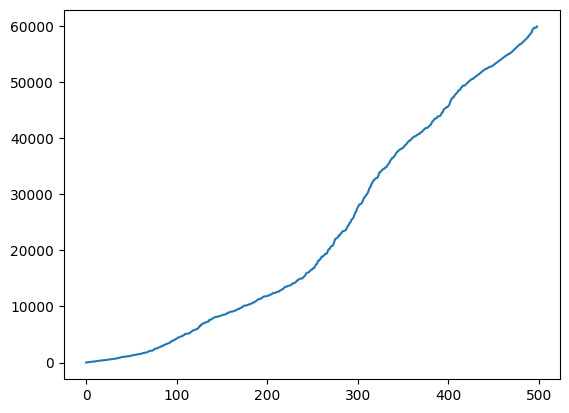

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
nrewards = np.array(rewards, dtype=float)
nrewards = np.cumsum(nrewards)
plt.plot(range(len(nrewards)), nrewards)
plt.show()

with open('results/dqn_rewards.pkl', 'wb') as f:
    pkl.dump(rewards, f)